In [3]:
import numpy as np
from scipy.optimize import differential_evolution

# Araç Parametreleri
veriler = {
    'kütle': 140,  # kg (sürücü hariç)
    'hava_yoğunluğu': 1.2,  # kg/m³
    'Cd': 0.3,  # Aerodinamik sürtünme katsayısı
    'frontal_alan': 1.6,  # m²
    'yuvarlanma_direnci': 0.015,  # Lastik yuvarlanma katsayısı
    'motor_gücü': 20,  # kW
    'tekerlek_çapı': 0.5,  # metre
    'hidrojen_verimliliği': 0.5,  # %50 verimli yakıt hücresi
    'batarya_kapasitesi': 5.5  # kWh
}

def hava_direnci(hız):
    """Hava direncinden kaynaklı kuvvet."""
    Cd = veriler['Cd']
    A = veriler['frontal_alan']
    rho = veriler['hava_yoğunluğu']
    return 0.5 * Cd * A * rho * hız**2

def yuvarlanma_kuvveti():
    """Yuvarlanma direncinden kaynaklı kuvvet."""
    Cr = veriler['yuvarlanma_direnci']
    kütle = veriler['kütle']
    g = 9.81  # Yerçekimi
    return Cr * kütle * g

def enerji_tüketimi(hız, tork):
    """Araç toplam enerji tüketimini hesaplar."""
    # Kuvvetlerin toplamı
    toplam_kuvvet = hava_direnci(hız) + yuvarlanma_kuvveti()
    
    # Harcanan enerji (kW cinsinden)
    harcanan_enerji = (toplam_kuvvet * hız) / 1000  # kW
    
    # Rejeneratif frenlemeden geri kazanılan enerji (%20)
    geri_kazanım = harcanan_enerji * 0.2
    
    # Net enerji tüketimi
    net_enerji = harcanan_enerji - geri_kazanım
    return net_enerji

def menzil_hesapla(params):
    """Optimizasyon için menzil hesaplar."""
    tork, hız = params
    net_enerji = enerji_tüketimi(hız / 3.6, tork)  # Hızı m/s'ye çevir
    
    # Hidrojen hücresi ve batarya toplam kapasitesi
    toplam_kapasite = veriler['hidrojen_verimliliği'] * veriler['batarya_kapasitesi']
    
    if net_enerji <= 0:
        return np.inf  # Enerji tüketimi negatifse sonsuz menzil
    
    # Menzil (km)
    menzil = toplam_kapasite / net_enerji
    return -menzil  # Maksimizasyon için negatif alınır

# Tork ve hız sınırları
sınırlar = [(150, 300),  # Tork (Nm)
            (10, 100)]   # Hız (km/h)

# Optimizasyonu çalıştır
sonuç = differential_evolution(menzil_hesapla, sınırlar)
opt_tork, opt_hız = sonuç.x
opt_menzil = -sonuç.fun

print(f"Optimum Tork: {opt_tork:.2f} Nm, Optimum Hız: {opt_hız:.2f} km/h, Tahmini Menzil: {opt_menzil:.2f} km")


Optimum Tork: 260.33 Nm, Optimum Hız: 10.00 km/h, Tahmini Menzil: 54.22 km


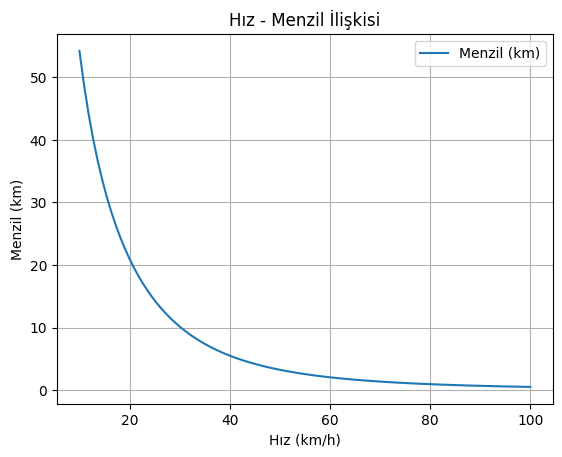

In [4]:
import matplotlib.pyplot as plt

# Hız değerleri için menzil grafiği
hız_aralığı = np.linspace(10, 100, 100)
menzil_değerleri = [-menzil_hesapla([opt_tork, hız]) for hız in hız_aralığı]

plt.plot(hız_aralığı, menzil_değerleri, label='Menzil (km)')
plt.xlabel('Hız (km/h)')
plt.ylabel('Menzil (km)')
plt.title('Hız - Menzil İlişkisi')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tork ve hız aralıklarını tanımla
tork_aralığı = np.linspace(150, 300, 10)  # 150-300 Nm arası tork
hız_aralığı = np.linspace(10, 100, 10)  # 10-100 km/h arası hız

# Boş DataFrame oluştur
sonuçlar = pd.DataFrame(columns=['Tork (Nm)', 'Hız (km/h)', 'Menzil (km)', 'Enerji Tüketimi (kWh)'])

def simülasyon_yap():
    """Her tork ve hız kombinasyonu için enerji tüketimi ve menzil hesapla."""
    global sonuçlar
    veri_listesi = []  # Geçici olarak verileri tutmak için liste

    for tork in tork_aralığı:
        for hız in hız_aralığı:
            net_enerji = enerji_tüketimi(hız / 3.6, tork)  # Hızı m/s'ye çevir
            if net_enerji > 0:
                menzil = (veriler['hidrojen_verimliliği'] * veriler['batarya_kapasitesi']) / net_enerji
            else:
                menzil = np.inf  # Sonsuz menzil varsayıyoruz (negatif enerji tüketimi)

            # Sonuçları geçici listeye ekle
            veri_listesi.append({
                'Tork (Nm)': tork,
                'Hız (km/h)': hız,
                'Menzil (km)': round(menzil, 2),
                'Enerji Tüketimi (kWh)': round(net_enerji, 2)
            })

    # Listeyi DataFrame'e dönüştür
    yeni_sonuçlar = pd.DataFrame(veri_listesi)

    # NA değer içeren tüm satırları çıkart
    yeni_sonuçlar_clean = yeni_sonuçlar.dropna(how='all')

    # Eğer temizlenen sonuçlar boş değilse ve NA içermiyorsa birleştir
    if not yeni_sonuçlar_clean.empty:
        sonuçlar = pd.concat([sonuçlar, yeni_sonuçlar_clean], ignore_index=True)
    else:
        print("Temizlenen sonuçlar boş veya tüm veriler NA değer içeriyor.")

# Simülasyonu çalıştır
simülasyon_yap()
print(sonuçlar.head())


   Tork (Nm)  Hız (km/h)  Menzil (km)  Enerji Tüketimi (kWh)
0      150.0        10.0        54.22                   0.05
1      150.0        20.0        20.98                   0.13
2      150.0        30.0        10.16                   0.27
3      150.0        40.0         5.51                   0.50
4      150.0        50.0         3.25                   0.85


C:\Users\Admin\AppData\Local\Temp\ipykernel_15780\2104191252.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sonuçlar = pd.concat([sonuçlar, yeni_sonuçlar_clean], ignore_index=True)


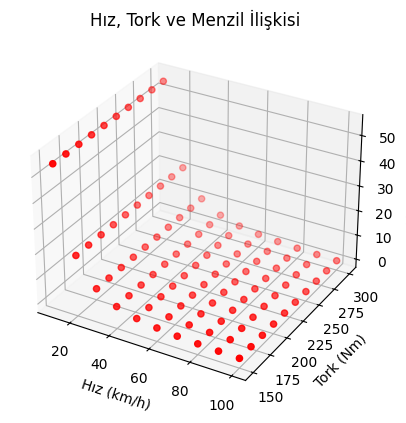

In [18]:
from mpl_toolkits.mplot3d import Axes3D

# 3B Grafik: Hız, Tork ve Menzil İlişkisi
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(sonuçlar['Hız (km/h)'], sonuçlar['Tork (Nm)'], sonuçlar['Menzil (km)'], c='r', marker='o')

ax.set_xlabel('Hız (km/h)')
ax.set_ylabel('Tork (Nm)')
ax.set_zlabel('Menzil (km)')
ax.set_title('Hız, Tork ve Menzil İlişkisi')

plt.show()


In [19]:
# En yüksek menzil sağlayan tork ve hız kombinasyonu
en_iyi_sonuç = sonuçlar.loc[sonuçlar['Menzil (km)'].idxmax()]

print(f"Optimum Tork: {en_iyi_sonuç['Tork (Nm)']} Nm")
print(f"Optimum Hız: {en_iyi_sonuç['Hız (km/h)']} km/h")
print(f"Tahmini Menzil: {en_iyi_sonuç['Menzil (km)']} km")


Optimum Tork: 150.0 Nm
Optimum Hız: 10.0 km/h
Tahmini Menzil: 54.22 km


Menzil Optimizasyonu Raporu

Veri Setinin Genel Özeti:
       Tork (Nm)  Hız (km/h)  Menzil (km)  Enerji Tüketimi (kWh)
count        5.0    5.000000     5.000000                 5.0000
mean       150.0   30.000000    18.824000                 0.3600
std          0.0   15.811388    20.930851                 0.3228
min        150.0   10.000000     3.250000                 0.0500
25%        150.0   20.000000     5.510000                 0.1300
50%        150.0   30.000000    10.160000                 0.2700
75%        150.0   40.000000    20.980000                 0.5000
max        150.0   50.000000    54.220000                 0.8500
Optimum Tork: 150.0 Nm
Optimum Hız: 10.0 km/h
Tahmini Menzil: 54.22 km



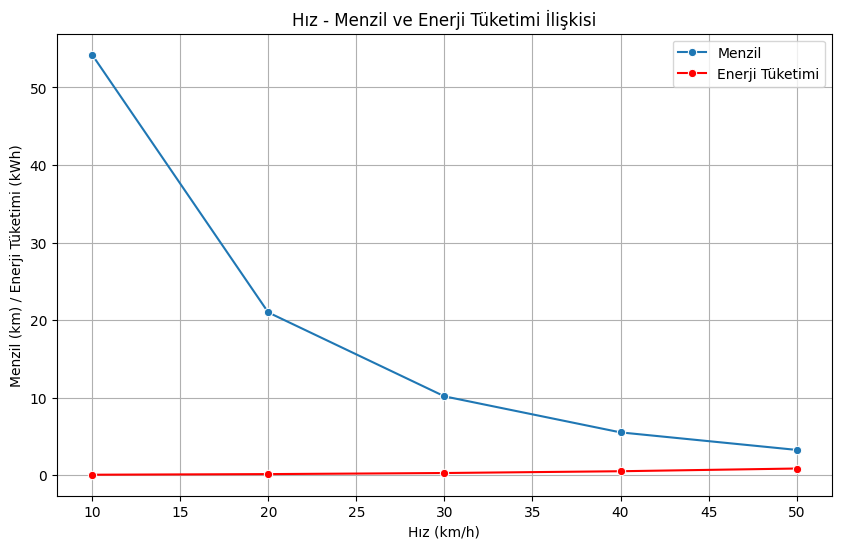

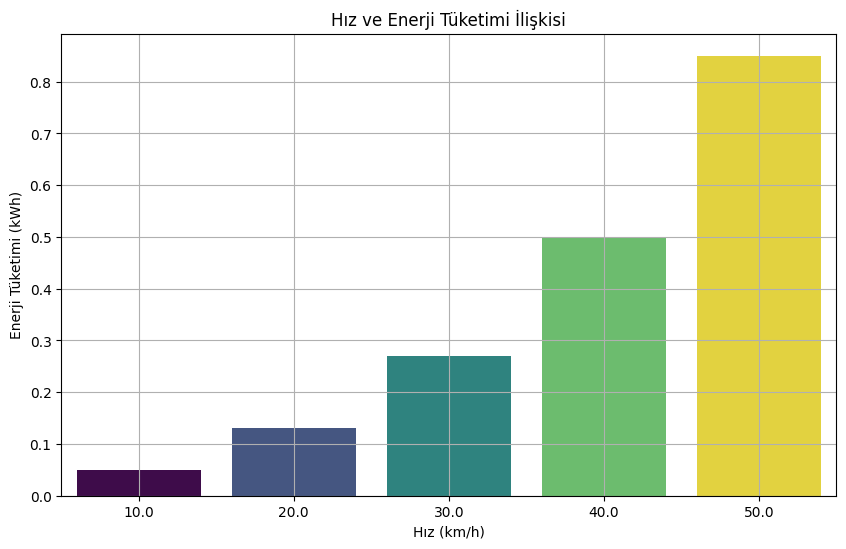

Rapor Sonuçları:
- Düşük hızlarda (10-20 km/h) enerji verimliliği yüksek, menzil maksimum.
- Hız arttıkça enerji tüketimi artıyor, menzil hızla düşüyor.
- 30 km/h ve üzeri hızlarda aerodinamik iyileştirmeler önerilebilir.
- Rejeneratif frenleme ve sabit hızda sürüş stratejileri menzili iyileştirebilir.


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Verilerinizi ekleyin
veriler = {
    'Tork (Nm)': [150.0, 150.0, 150.0, 150.0, 150.0],
    'Hız (km/h)': [10.0, 20.0, 30.0, 40.0, 50.0],
    'Menzil (km)': [54.22, 20.98, 10.16, 5.51, 3.25],
    'Enerji Tüketimi (kWh)': [0.05, 0.13, 0.27, 0.50, 0.85]
}

# DataFrame oluştur
df = pd.DataFrame(veriler)

# Optimum sonuçlar
optimum_tork = 150.0
optimum_hız = 10.0
optimum_menzil = 54.22

# 1. Verilerin Genel Özeti
def veri_ozeti(df):
    print("Veri Setinin Genel Özeti:")
    print(df.describe())

# 2. Menzil ve Enerji Tüketimi İlişkisi
def grafik_menzil_enerji(df):
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Hız (km/h)', y='Menzil (km)', data=df, marker='o', label='Menzil')
    sns.lineplot(x='Hız (km/h)', y='Enerji Tüketimi (kWh)', data=df, marker='o', label='Enerji Tüketimi', color='r')
    plt.title('Hız - Menzil ve Enerji Tüketimi İlişkisi')
    plt.xlabel('Hız (km/h)')
    plt.ylabel('Menzil (km) / Enerji Tüketimi (kWh)')
    plt.legend()
    plt.grid(True)
    plt.show()

# 3. Optimum Değerlerin Vurgulanması
def optimum_degerler(df, optimum_tork, optimum_hız, optimum_menzil):
    print(f"Optimum Tork: {optimum_tork} Nm")
    print(f"Optimum Hız: {optimum_hız} km/h")
    print(f"Tahmini Menzil: {optimum_menzil} km\n")

# 4. # Tork ve Hızın Enerji Tüketimi Üzerindeki Etkisi
def grafik_tork_ve_hiz(df):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Hız (km/h)', y='Enerji Tüketimi (kWh)', data=df, hue='Hız (km/h)', palette='viridis', legend=False)
    plt.title('Hız ve Enerji Tüketimi İlişkisi')
    plt.xlabel('Hız (km/h)')
    plt.ylabel('Enerji Tüketimi (kWh)')
    plt.grid(True)
    plt.show()

# 5. Rapor Sonuçları
def rapor_sonuclari():
    print("Rapor Sonuçları:")
    print("- Düşük hızlarda (10-20 km/h) enerji verimliliği yüksek, menzil maksimum.")
    print("- Hız arttıkça enerji tüketimi artıyor, menzil hızla düşüyor.")
    print("- 30 km/h ve üzeri hızlarda aerodinamik iyileştirmeler önerilebilir.")
    print("- Rejeneratif frenleme ve sabit hızda sürüş stratejileri menzili iyileştirebilir.")

# 6. Tüm Raporu Çalıştır
def rapor(df):
    print("Menzil Optimizasyonu Raporu\n")
    veri_ozeti(df)
    optimum_degerler(df, optimum_tork, optimum_hız, optimum_menzil)
    grafik_menzil_enerji(df)
    grafik_tork_ve_hiz(df)
    rapor_sonuclari()

# Raporu Çalıştır
rapor(df)
